Calculation of Unmixing Coefficients and G Parameter
====================================================
---
_Borys Olifirov, 07.2023_

## Theoretical intro

Based on _Zal and Gascoigne, 2004, doi: 10.1529/biophysj.103.022087_

__Intensity notation__

$$I_{XM(T)}$$

- X - excitation type
- M - emission type
- T - transfection type (A if acceptor only cells), does not present for co-transfected cells


#### Sensitized-emission

$$F_c = I_{DA} - a I_{AA} - d I_{DD}$$


#### Crosstalc caliration

$$a = \frac{I_{DA(A)}}{I_{AA(A)}}$$
$$b = \frac{I_{DD(A)}}{I_{AA(A)}}$$
$$c = \frac{I_{AA(D)}} {I_{DD(D)}}$$
$$d = \frac{I_{DA(D)}} {I_{DD(D)}}$$

$$b \approx c \approx 0$$


#### Determination of the G parameter

$$G = \frac{F_c}{I_{DD}^{post} - I_{DD}} = \frac{(I_{DA} - a I_{AA} - d I_{DD}) - (I_{DA}^{post} - a I_{AA}^{post} - d I_{DD}^{post})}{I_{DD}^{post} - I_{DD}}$$


#### E-FRET

$$E_{app} = \frac{R}{R+G}, R = \frac{F_c}{I_{DD}}$$

$$E_{corr} = E_{app}(t) \frac{[A^0]_{tot}}{[A^t]_{tot}} = E_{app}(t) \times \frac{\overline{I_{AA}^0 - c I_{DD}^0}}{\overline{I_{AA}(t) - c I_{DD}(t)}}$$

## Script

In [1]:
import os
import sys
import glob
import yaml

import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io
from skimage import transform
from skimage import registration

from scipy import ndimage
from scipy import signal
from scipy import stats
from scipy import ndimage as ndi

## Crosstalk

#### Uploading donor

In [60]:
class CrossReg():
    def __init__(self, data_path, data_name, reg_type):
        self.img_name = data_name
        self.img_type = reg_type
        self.img_path = data_path
        self.img_raw = io.imread(self.img_path)

        self.ch0_img = self.img_raw[:,:,:,0]  # CFP-435
        self.ch1_img = self.img_raw[:,:,:,1]  # YFP-435
        self.ch2_img = self.img_raw[:,:,:,2]  # CFP-505
        self.ch3_img = self.img_raw[:,:,:,3]  # YFP-505

        self.ch0_mean_img = np.mean(self.ch0_img, axis=0)
        self.ch1_mean_img = np.mean(self.ch1_img, axis=0)
        self.ch2_mean_img = np.mean(self.ch2_img, axis=0)
        self.ch3_mean_img = np.mean(self.ch3_img, axis=0)


    def cross_calc(self):
        if self.img_type == 'A':
            self.a_arr = np.asarray([np.mean(self.ch1_img[i] / self.ch3_img[i]) for i in range(0, self.img_raw.shape[0])])
            self.b_arr = np.asarray([np.mean(self.ch2_img[i] / self.ch3_img[i]) for i in range(0, self.img_raw.shape[0])])

            plt.plot(self.a_arr, label='a')
            plt.plot(self.b_arr, label='b')
            plt.legend()

        elif self.img_type == 'D':
            self.c_arr = np.asarray([np.mean(self.ch3_img[i] / self.ch0_img[i]) for i in range(0, self.img_raw.shape[0])])
            self.d_arr = np.asarray([np.mean(self.ch1_img[i] / self.ch0_img[i]) for i in range(0, self.img_raw.shape[0])])

            plt.plot(self.c_arr, label='c')
            plt.plot(self.d_arr, label='d')
            plt.legend()


    def plot_hist(self):
        plt.figure(figsize=(8,8))

        ax0 = plt.subplot(211)
        ax0.hist(self.ch0_mean_img.ravel(), bins=256,
                 alpha=.5,label='Ch 0 (CFP-435)', color='r')
        ax0.hist(self.ch1_mean_img.ravel(), bins=256,
                 alpha=.5, label='Ch 1 (YFP-435)', color='g')
        ax0.hist(self.ch2_mean_img.ravel(), bins=256,
                 alpha=.5, label='Ch 2 (CFP-505)', color='y')
        ax0.hist(self.ch3_mean_img.ravel(), bins=256,
                 alpha=.5, label='Ch 3 (YFP-505)', color='b')
        ax0.legend()

        plt.title(f'File {self.img_name}, type {self.img_type}')
        plt.tight_layout()
        plt.show()


    def ff_profile(self):
        plt.figure(figsize=(8,4))

        ax0 = plt.subplot()
        ax0.plot(np.mean(self.ch0_img, axis=(1,2)),
                 label='Ch 0 (CFP-435)', color='r')
        ax0.plot(np.mean(self.ch1_img, axis=(1,2)),
                 label='Ch 1 (YFP-435)', color='g')
        ax0.plot(np.mean(self.ch2_img, axis=(1,2)),
                 label='Ch 2 (CFP-505)', color='y')
        ax0.plot(np.mean(self.ch3_img, axis=(1,2)),
                 label='Ch 3 (YFP-505)', color='b')
        ax0.legend()

        plt.title(f'File {self.img_name}, type {self.img_type}')
        plt.tight_layout()
        plt.show()        


    def plot_ch_pannels(self):
        int_min = np.min(self.img_raw)
        int_max = np.max(self.img_raw)


        plt.figure(figsize=(10,10))

        ax0 = plt.subplot(221)
        ax0.set_title('Ch.0')
        img0 = ax0.imshow(self.ch0_mean_img, cmap='jet')
        img0.set_clim(vmin=int_min, vmax=int_max)
        div0 = make_axes_locatable(ax0)
        cax0 = div0.append_axes('right', size='3%', pad=0.1)
        plt.colorbar(img0, cax=cax0)
        ax0.axis('off')

        ax1 = plt.subplot(222)
        ax1.set_title('Ch.1')
        img1 = ax1.imshow(self.ch1_mean_img, cmap='jet')
        img1.set_clim(vmin=int_min, vmax=int_max)
        div1 = make_axes_locatable(ax1)
        cax1 = div1.append_axes('right', size='3%', pad=0.1)
        plt.colorbar(img1, cax=cax1)
        ax1.axis('off')

        ax2 = plt.subplot(223)
        ax2.set_title('Ch.2')
        img2 = ax2.imshow(self.ch2_mean_img, cmap='jet')
        img2.set_clim(vmin=int_min, vmax=int_max)
        div2 = make_axes_locatable(ax2)
        cax2 = div2.append_axes('right', size='3%', pad=0.1)
        plt.colorbar(img2, cax=cax2)
        ax2.axis('off')

        ax3 = plt.subplot(224)
        ax3.set_title('Ch.3')
        img3 = ax3.imshow(self.ch3_mean_img, cmap='jet')
        img3.set_clim(vmin=int_min, vmax=int_max)
        div3 = make_axes_locatable(ax3)
        cax3 = div3.append_axes('right', size='3%', pad=0.1)
        plt.colorbar(img3, cax=cax3)
        ax3.axis('off')

        plt.title(f'File {self.img_name}, type {self.img_type}')
        plt.tight_layout()
        plt.show()

        

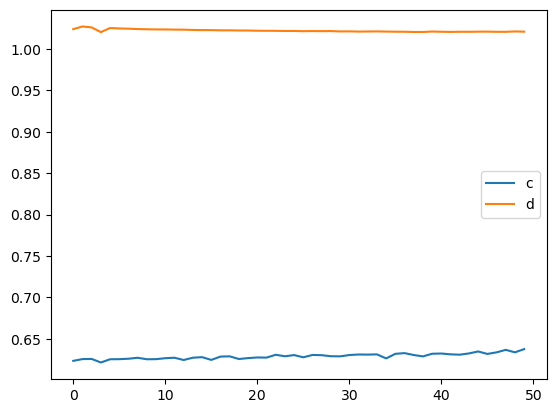

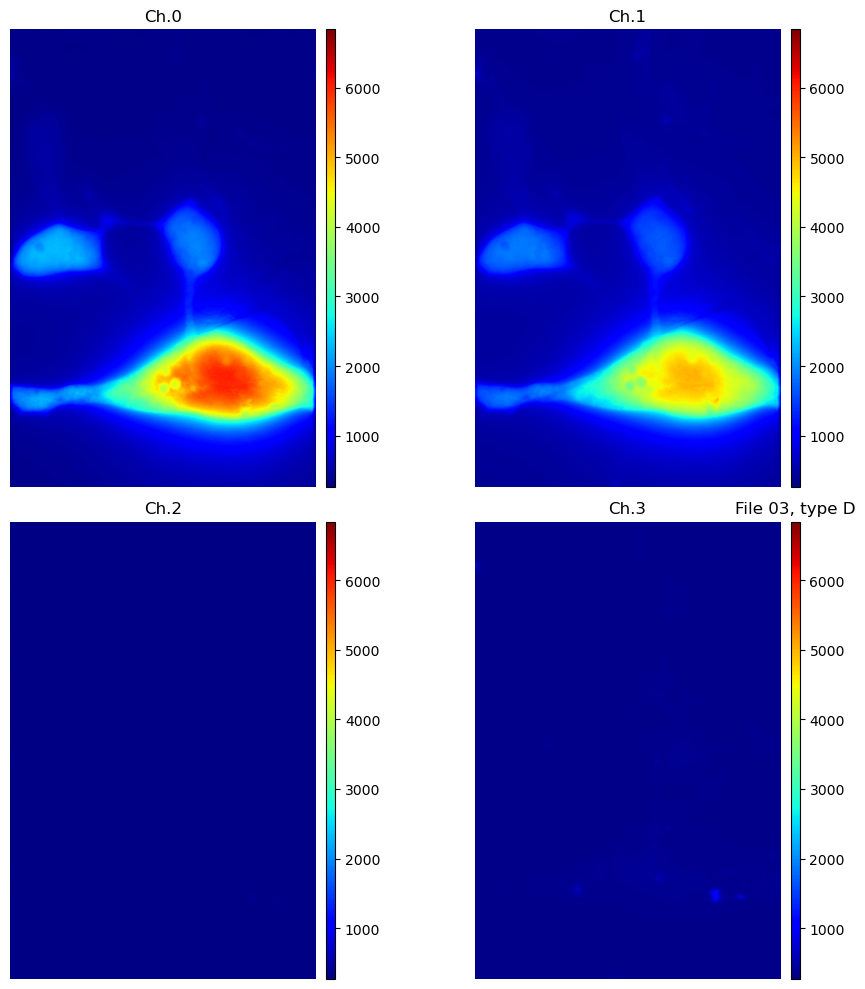

In [63]:
img_path = 'data/crosstalk/'

donor_names = ['01', '02', '03']
acceptor_names = ['04', '05', '06']

donor_img_list = []
for name in donor_names:
    name_path = img_path + f'{name}.tif'
    donor_img_list.append(CrossReg(data_path=name_path,
                                   data_name=name,
                                   reg_type='D'))
acceptor_img_list = []
for name in acceptor_names:
    name_path = img_path + f'{name}.tif'
    acceptor_img_list.append(CrossReg(data_path=name_path,
                                   data_name=name,
                                   reg_type='A'))

# donor_img_list[0].plot_hist()
donor_img_list[2].cross_calc()
donor_img_list[2].plot_ch_pannels()


# acceptor_img_list[0].ff_profile()
# acceptor_img_list[2].cross_calc()
# acceptor_img_list[2].plot_ch_pannels()

## G parameter